Important imports and array handling and plotting

In [13]:
%matplotlib inline

In [14]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

import os
os.environ['TP_CPP_MIN_LOG_LEVEL']='3'

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

Loading dataset and splitting it into train and test sets

In [15]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plotting some examples

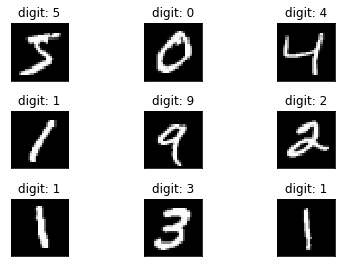

In [16]:
fig = plt.figure()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("digit: {}".format(y_train[i]))
    plt.xticks([])
    plt.yticks([])
fig

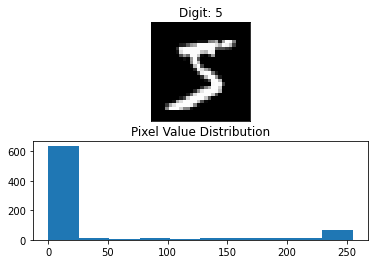

In [17]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")
fig

In [18]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


In [19]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [20]:
# normalizing the data to help with the training
X_train /= 255
X_test /= 255

In [21]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


In [24]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [23]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [26]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

In [27]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 5s - loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.1360 - val_accuracy: 0.9847
Epoch 2/20
 - 5s - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.1403 - val_accuracy: 0.9833
Epoch 3/20
 - 5s - loss: 0.0100 - accuracy: 0.9976 - val_loss: 0.1299 - val_accuracy: 0.9849
Epoch 4/20
 - 6s - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.1508 - val_accuracy: 0.9826
Epoch 5/20
 - 5s - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.1392 - val_accuracy: 0.9848
Epoch 6/20
 - 5s - loss: 0.0090 - accuracy: 0.9977 - val_loss: 0.1451 - val_accuracy: 0.9832
Epoch 7/20
 - 5s - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.1572 - val_accuracy: 0.9828
Epoch 8/20
 - 5s - loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.1499 - val_accuracy: 0.9845
Epoch 9/20
 - 5s - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.1368 - val_accuracy: 0.9845
Epoch 10/20
 - 5s - loss: 0.0095 - accuracy: 0.9979 - val_loss: 0.1437 - val_accuracy: 0.9834
Epoch 11/20
 - 5s -

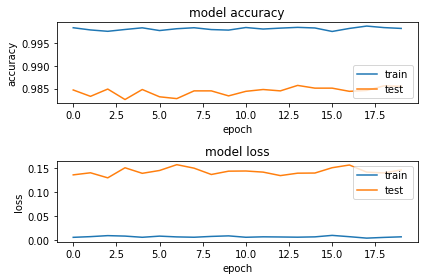

In [33]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=20,
          verbose=2,
          validation_data=(X_test, Y_test))

# saving the model
save_dir = "/home/yerbolat/MOSIG/Semester2/Intelligent_Systems/results/"
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [40]:
mnist_model = load_model('/home/yerbolat/MOSIG/Semester2/Intelligent_Systems/results/keras_mnist.h5')
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

Test Loss 0.14629027374301795
Test Accuracy 0.9854999780654907



9855  classified correctly
145  classified incorrectly


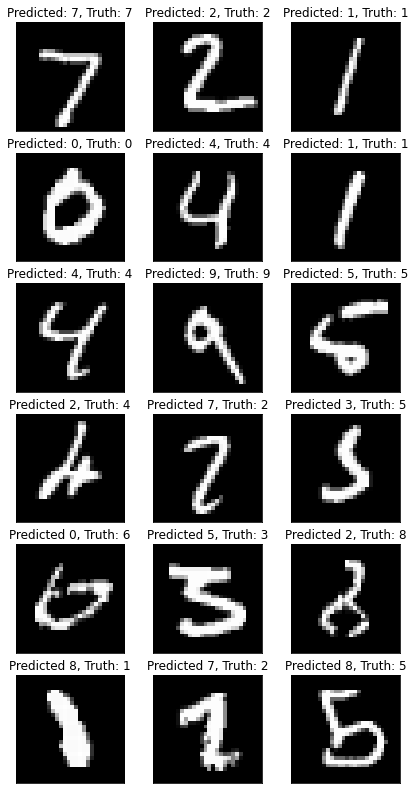

In [41]:
# load the model and create predictions on the test set
mnist_model = load_model('/home/yerbolat/MOSIG/Semester2/Intelligent_Systems/results/keras_mnist.h5')
predicted_classes = mnist_model.predict_classes(X_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

figure_evaluation